In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.gridspec import GridSpec
import pylab
import hickle as hkl


from InflGame.adaptive.visualization import Shell
import InflGame.utils.general as general
import InflGame.domains.rd as rd

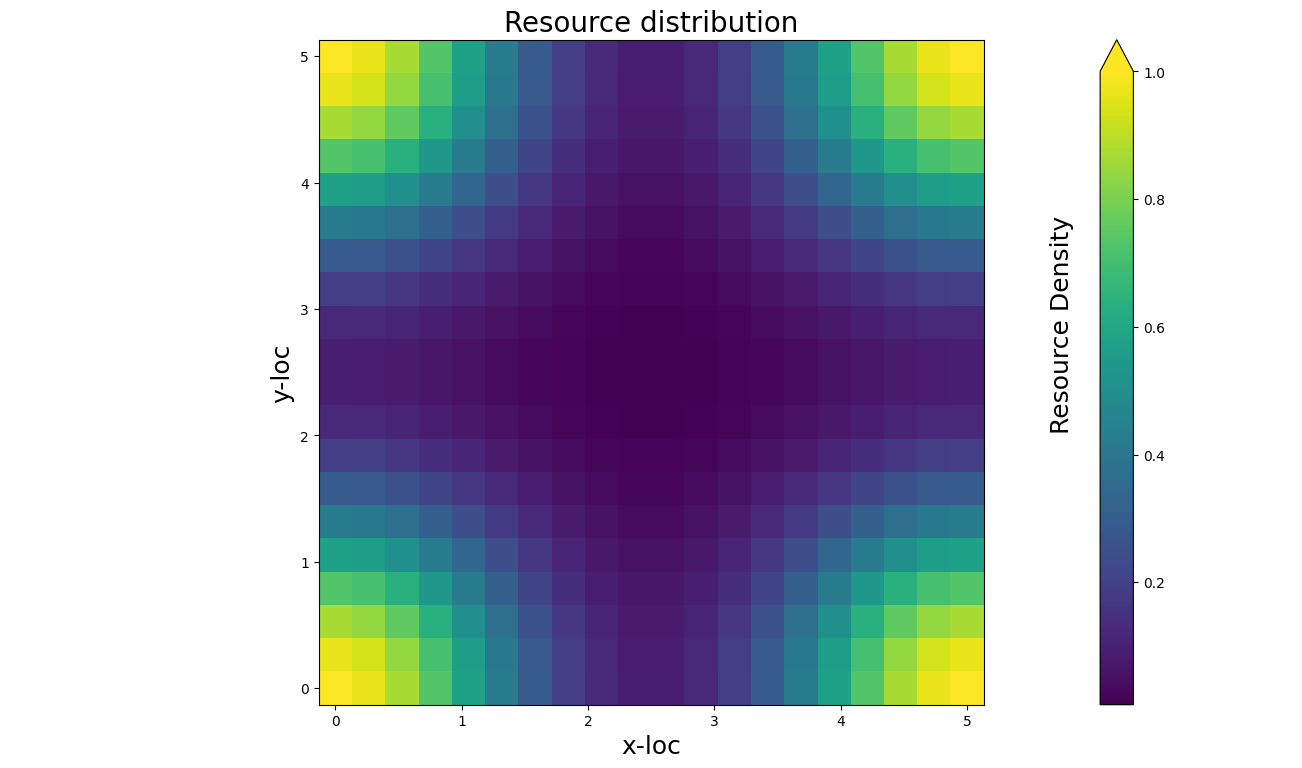

In [2]:
domain_type='2d'
domain_bounds=np.array([[0,5],[0,5]])
font_size_labels=18
font_size_title=20
domain_refinement=20
rect_Y, rect_X = np.mgrid[domain_bounds[0,0]:domain_bounds[0,1]:domain_refinement*1j, domain_bounds[1,0]:domain_bounds[1,1]:domain_refinement*1j]
rect_positions = np.vstack([rect_X.ravel(), rect_Y.ravel()])
rect_positions=rect_positions.transpose()
fig = plt.figure(figsize=(19, 7))
gs = GridSpec(nrows=1, ncols=1,width_ratios=[1],wspace=0.0, hspace=0.2, top=1, bottom=0.05, left=0.17, right=0.845)
ax0 = fig.add_subplot(gs[:, 0])
ax0.set_box_aspect(1)
current_alpha=5
resource_parameters_MVG=[torch.tensor([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1.0]]]),torch.tensor([[0,0],[current_alpha,0],[0, current_alpha],[current_alpha,current_alpha]])]
resource_type='multi_modal_gaussian_distribution_2D_square'

resources=rd.resource_distribution_choice(bin_points=rect_positions,resource_type=resource_type,resource_parameters=resource_parameters_MVG)
pval=resources.reshape(len(rect_Y),len(rect_X))
im = ax0.pcolormesh(rect_X,rect_Y, pval)

# Make the plot square
ax0.set_box_aspect(1) 
plt.title('Resource distribution',fontsize=font_size_title)
plt.xlabel('x-loc',fontsize=font_size_labels)
plt.ylabel('y-loc',fontsize=font_size_labels)

ax1 = fig.add_subplot(gs[:, 0])
cbar=fig.colorbar(im,ax=ax1, extend='max',location='right',ticklocation='left')
ax1.yaxis.set_ticks_position('left')
ax1.set_box_aspect(.1)
ax1.axis('off')

ax2 = fig.add_subplot(gs[:, 0])
ax2.axis('off')
ax2.set_box_aspect(.1)
ax2.set_title('Resource Density',x=.82, y=0, rotation = 90,size=font_size_labels)
# Add a colorbar




fig.savefig('2d_square_alpha_1.svg',bbox_inches='tight')

In [3]:
def custom_infl_2d(x_torch:torch.Tensor,
                   bin_points:np.ndarray,
                   parameter_instance:torch.Tensor,
                   )->torch.Tensor:
    """
    Custom 2D influence function that returns influence matrix for multiple agents
    INPUTS:
        x_torch: Agent positions - shape (N, 2) for N agents
        bin_points: Resource bin points - shape (M, 2) for M points  
        parameter_instance: Parameters for each agent - shape (N,) or (N, 1)
    OUTPUTS:
        influence_matrix: Influence values - shape (N, M)
    """
    if not torch.is_tensor(x_torch):
        x_torch = torch.tensor(x_torch, dtype=torch.float32)
    if not torch.is_tensor(parameter_instance):
        parameter_instance = torch.tensor(parameter_instance, dtype=torch.float32)
    if not torch.is_tensor(bin_points):
        bin_points = torch.tensor(bin_points, dtype=torch.float32)
    
    # Ensure proper shapes
    if x_torch.dim() == 1:
        x_torch = x_torch.unsqueeze(0)  # Shape: (1, 2)
    if parameter_instance.dim() == 1:
        parameter_instance = parameter_instance.unsqueeze(-1)  # Shape: (N, 1)
    
    # Calculate distances: (N, 1, 2) - (1, M, 2) -> (N, M, 2)
    x_expanded = x_torch.unsqueeze(1)  # Shape: (N, 1, 2)
    bin_expanded = bin_points.unsqueeze(0)  # Shape: (1, M, 2)
    distances = x_expanded - bin_expanded  # Shape: (N, M, 2)
    
    # Calculate influence using L2 norm and parameter
    # distances shape: (N, M, 2), norm gives (N, M)
    distance_norms = torch.norm(distances, dim=2)  # Shape: (N, M)
    
    # Apply influence function - using exponential decay with parameter
    influence_matrix = torch.exp(-distance_norms * parameter_instance)  # Shape: (N, M)
    
    return influence_matrix

In [4]:
int_agents_pos=general.agent_position_setup(num_agents=4,setup_type="initial_symmetric_setup",domain_type=domain_type,domain_bounds=domain_bounds)
custom_infl_2d(x_torch=int_agents_pos,bin_points=rect_positions,parameter_instance=[1,2,3,4])

C:\Users\Mark-Fu-Lab\AppData\Local\Temp\ipykernel_65464\1177540011.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_torch = torch.tensor(x_torch, dtype=torch.float32)


tensor([[1.0000e+00, 7.6862e-01, 5.9078e-01,  ..., 1.2196e-03, 1.0205e-03,
         8.4933e-04],
        [4.5400e-05, 4.4776e-05, 4.2960e-05,  ..., 1.3008e-04, 7.6848e-05,
         4.5400e-05],
        [3.0590e-07, 6.7367e-07, 1.4836e-06,  ..., 2.8157e-07, 2.9962e-07,
         3.0590e-07],
        [5.2035e-13, 1.0844e-12, 2.2124e-12,  ..., 1.2181e-01, 3.4902e-01,
         1.0000e+00]])

In [5]:
from InflGame.kernels.MV_gauss import cov_matrix_vectorized
num_agents=4
infl_configs={"infl_type":"custom","custom_influence":custom_infl_2d}
domain_type='2d'
int_agents_pos=general.agent_position_setup(num_agents=num_agents,setup_type="initial_symmetric_setup",domain_type=domain_type,domain_bounds=domain_bounds)
#int_agents_pos=[[7.5,7.5],[7.5,7.5],[7.5,7.5],[7.5,7.5]] 
parameters=[1,2,3,4]
bin_points=rect_positions
resource_distribution=resources
lr_type='cosine_annealing' #static or cosine
learning_rate=[1/50,1/10,250]
time_steps=500

vis=Shell(num_agents=num_agents, agents_pos=int_agents_pos.copy(), parameters=parameters,resource_distribution=resource_distribution,bin_points=bin_points,infl_configs=infl_configs,learning_rate_type=lr_type,learning_rate=learning_rate,time_steps=time_steps,domain_type=domain_type,domain_bounds=domain_bounds,resource_type=resource_type,domain_refinement=domain_refinement,tolerance=.000001)

In [6]:
vis.setup_adaptive_env()
vis.field.gradient_ascent()
og_pos_matrix=vis.field.pos_matrix
og_grad_matrix=vis.field.grad_matrix
vis.agents_pos=int_agents_pos.copy()
vis.field.agents_pos=int_agents_pos.copy()

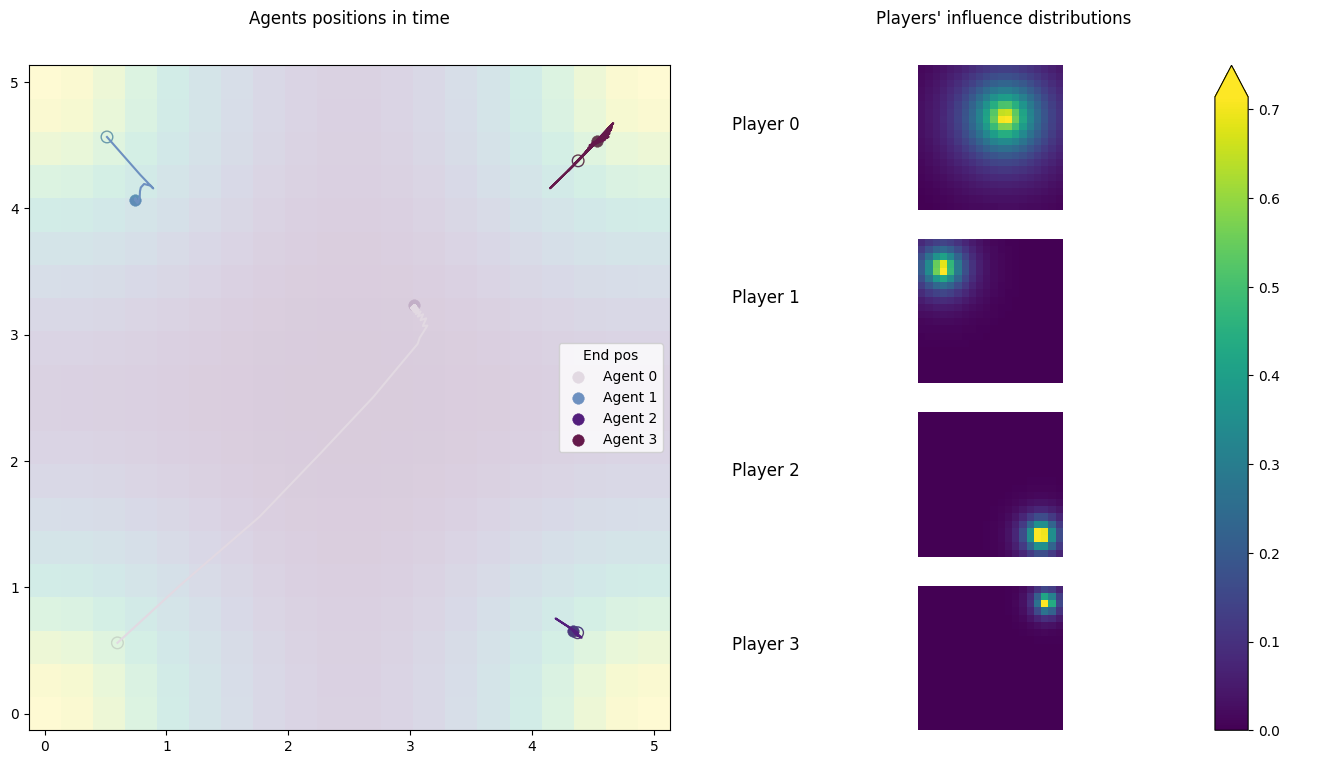

In [7]:
vis.dist_pos_gif(max_frames=1)

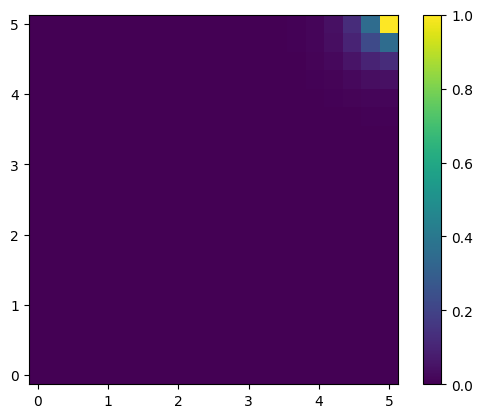

In [14]:
vis.dist_plot(3,parameter_instance=vis.parameters)